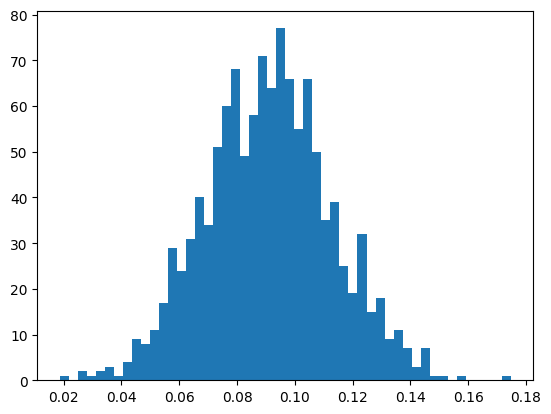

                                 OLS Regression Results                                
Dep. Variable:             Excess_ETF   R-squared (uncentered):                   0.954
Model:                            OLS   Adj. R-squared (uncentered):              0.954
Method:                 Least Squares   F-statistic:                              8081.
Date:                Sun, 03 Aug 2025   Prob (F-statistic):                        0.00
Time:                        19:12:59   Log-Likelihood:                          3273.9
No. Observations:                1176   AIC:                                     -6542.
Df Residuals:                    1173   BIC:                                     -6527.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Generate synthetic data for demonstration
np.random.seed(42)

# Dates for the example
dates = pd.date_range(start='1926-01-01', end='2024-01-01', freq='M')

# Simulated returns for the ETF and benchmark indices
num_months = len(dates)
etf_returns = np.random.normal(loc=0.09, scale=0.022, size=num_months)  # Mean return of 1% with 3% standard deviation
market_index_returns = np.random.normal(loc=0.071, scale=0.005, size=num_months)  # Mean return of 2% with 4% standard deviation
size_index_returns = np.random.normal(loc=0.08, scale=0.04, size=num_months)  # Mean return of 1.5% with 3.5% standard deviation
value_index_returns = np.random.normal(loc=0.095, scale=0.04, size=num_months)  # Mean return of 2% with 4% standard deviation


# M, S, V, P 
# C1 x M + C2 x S + C3 x V = P
plt.hist(etf_returns, bins=50)
plt.show()

etf_returns = 0.84*market_index_returns + 0.1*size_index_returns + 0.06*value_index_returns + np.random.normal(0, 0.015, size=num_months)

# Create DataFrames
etf_prices = pd.DataFrame({'Date': dates, 'ETF_Return': etf_returns})
etf_prices.set_index('Date', inplace=True)

market_index_prices = pd.DataFrame({'Date': dates, 'Market_Return': market_index_returns})
market_index_prices.set_index('Date', inplace=True)

size_index_prices = pd.DataFrame({'Date': dates, 'Size_Return': size_index_returns})
size_index_prices.set_index('Date', inplace=True)

value_index_prices = pd.DataFrame({'Date': dates, 'Value_Return': value_index_returns})
value_index_prices.set_index('Date', inplace=True)

# Combine into a single DataFrame
returns_df = pd.concat([etf_prices, market_index_prices, size_index_prices, value_index_prices], axis=1)

# Calculate excess returns
risk_free_rate = 0.005  # Assume a risk-free rate of 0.5%
returns_df['Excess_ETF'] = returns_df['ETF_Return'] - risk_free_rate
returns_df['Excess_Market'] = returns_df['Market_Return'] - risk_free_rate
returns_df['Excess_Size'] = returns_df['Size_Return'] - risk_free_rate
returns_df['Excess_Value'] = returns_df['Value_Return'] - risk_free_rate

# Add some noise
#returns_df += np.random.normal(0, 0.01, returns_df.shape)

# Regression
X = returns_df[['Excess_Market', 'Excess_Size', 'Excess_Value']]
#X = sm.add_constant(X)
y = returns_df['Excess_ETF']
model = sm.OLS(y, X).fit()

# Print regression results
print(model.summary())

# r = r_f + beta_m * M + beta_smb * "SMB" + beta_hml * HML + 

In [16]:
#Data Fetcher MONTHLY DATA
import pandas as pd
import io
import requests
import zipfile
import numpy as np
from scipy.stats import t
import matplotlib.pyplot as plt

def fetch_ff5_monthly():
    """
    Fetches Fama-French 5-Factor monthly data (2x3 CSV format),
    parses only the monthly rows, converts percentages to decimals,
    and returns a clean DataFrame with datetime index.
    """
    url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
    r = requests.get(url)
    
    # Open the ZIP file from bytes
    with zipfile.ZipFile(io.BytesIO(r.content)) as z:
        # Find the CSV file
        csv_filename = next(name for name in z.namelist() if name.lower().endswith('.csv'))
        with z.open(csv_filename) as f:
            lines = f.read().decode('utf-8').splitlines()
    
    # Locate the header row
    header_idx = next(i for i, line in enumerate(lines) if "Mkt-RF" in line and "RF" in line)
    header = lines[header_idx].strip().split(',')
    
    # Collect only the monthly data lines (lines starting with YYYYMM)
    data_lines = []
    for line in lines[header_idx + 1:]:
        if not line.strip() or not line[:6].isdigit():
            break
        data_lines.append(line.strip())
    
    # Create DataFrame
    df = pd.read_csv(io.StringIO("\n".join(data_lines)), names=header)
    
    # Parse date and set as index
    df[header[0]] = pd.to_datetime(df[header[0]], format="%Y%m")
    df.set_index(header[0], inplace=True)
    
    # Convert percentages to decimals
    df = df / 100
    
    return df

#check
ff_factors = fetch_ff5_monthly()
print(ff_factors.head())
"""A general function to compute and display statistics for a given factor spread.

   Sample usage could be:

   factor_stats(High, Low, "HML")
   factor_stats(Small, Large, "SMB")
   factor_stats(Conservative, Aggressive, "CMA")

"""
def factor_stats(high, low, factor_name="Factor"):
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.stats import t

    spread = high - low
    plt.hist(spread, bins=100)
    plt.axvline(np.mean(spread), color='black', linestyle='--')
    plt.title(f"{factor_name} Distribution")
    plt.show()

    cumulative = [1]
    for r in spread:
        cumulative.append(cumulative[-1] * (1 + r))

    ann = (cumulative[-1]/cumulative[0])**(12/len(spread)) - 1
    print(f"Annualized {factor_name}: {ann*100:.2f}%")

    mean, std = np.mean(spread), np.std(spread)
    n = len(spread)
    t_stat = mean / (std / np.sqrt(n))
    p_value = t.sf(np.abs(t_stat), n-1)*2
    print(f"t-stat: {t_stat:.2f}, p-value: {p_value:.4f}")
    plt.plot(cumulative)
    plt.title(f"Cumulative {factor_name}")
    plt.show()


            Mkt-RF     SMB     HML     RMW     CMA      RF
                                                          
1963-07-01 -0.0039 -0.0048 -0.0081  0.0064 -0.0115  0.0027
1963-08-01  0.0508 -0.0080  0.0170  0.0040 -0.0038  0.0025
1963-09-01 -0.0157 -0.0043  0.0000 -0.0078  0.0015  0.0027
1963-10-01  0.0254 -0.0134 -0.0004  0.0279 -0.0225  0.0029
1963-11-01 -0.0086 -0.0085  0.0173 -0.0043  0.0227  0.0027


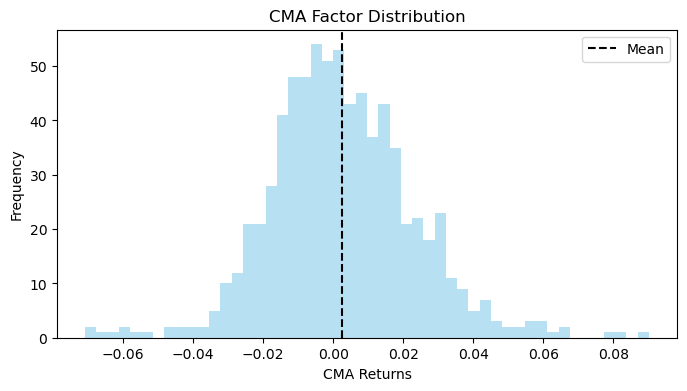

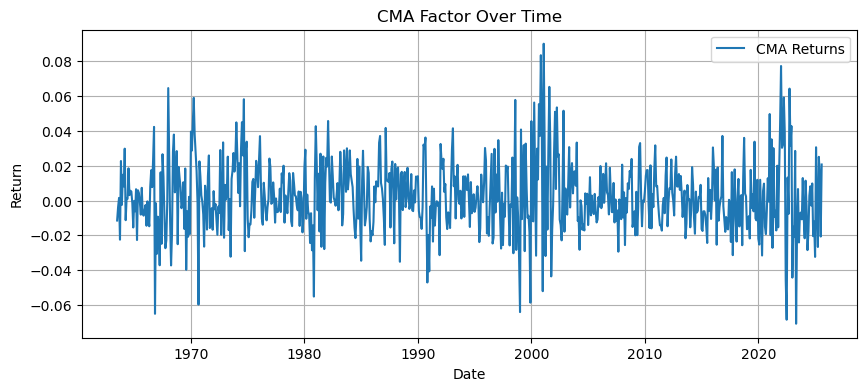

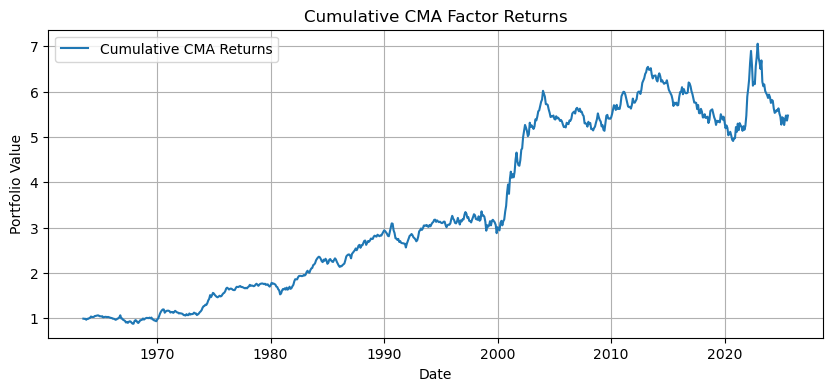

Annualized CMA: 2.77%
t-stat: 3.3024, p-value: 0.0010


In [19]:

# Fetch the Fama-French 5-factor monthly data 
ff_factors = fetch_ff5_monthly()

# --- USE REAL CMA RETURNS ---
cma_returns = ff_factors['CMA'].dropna()  # already in decimal form

# --- DISTRIBUTION PLOT ---
plt.figure(figsize=(8,4))
plt.hist(cma_returns, bins=50, alpha=0.6, color='skyblue')
plt.axvline(np.mean(cma_returns), color='black', linestyle='--', label='Mean')
plt.title('CMA Factor Distribution')
plt.xlabel('CMA Returns')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# --- TIME SERIES PLOT ---
plt.figure(figsize=(10,4))
plt.plot(cma_returns, label='CMA Returns')
plt.title('CMA Factor Over Time')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.show()

# --- CUMULATIVE RETURNS ---
cumulative = (1 + cma_returns).cumprod()
plt.figure(figsize=(10,4))
plt.plot(cumulative, label='Cumulative CMA Returns')
plt.title('Cumulative CMA Factor Returns')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.show()

# --- ANNUALIZED RETURN ---
cumulative = (1 + cma_returns).cumprod()
annualized = (cumulative.iloc[-1])**(12/len(cma_returns)) - 1
print(f"Annualized CMA: {annualized*100:.2f}%")

# --- T-STATISTIC AND P-VALUE ---
mean_return = np.mean(cma_returns)
std_dev = np.std(cma_returns, ddof=1)  # sample std
n = len(cma_returns)
t_stat = mean_return / (std_dev / np.sqrt(n))
p_value = t.sf(np.abs(t_stat), n-1) * 2  # two-tailed test

print(f"t-stat: {t_stat:.4f}, p-value: {p_value:.4f}")


            Mkt-RF     SMB     HML     RMW     CMA      RF
                                                          
1963-07-01 -0.0039 -0.0048 -0.0081  0.0064 -0.0115  0.0027
1963-08-01  0.0508 -0.0080  0.0170  0.0040 -0.0038  0.0025
1963-09-01 -0.0157 -0.0043  0.0000 -0.0078  0.0015  0.0027
1963-10-01  0.0254 -0.0134 -0.0004  0.0279 -0.0225  0.0029
1963-11-01 -0.0086 -0.0085  0.0173 -0.0043  0.0227  0.0027
...            ...     ...     ...     ...     ...     ...
2025-04-01 -0.0084 -0.0186 -0.0340 -0.0285 -0.0267  0.0035
2025-05-01  0.0606 -0.0072 -0.0288  0.0126  0.0251  0.0038
2025-06-01  0.0486 -0.0002 -0.0160 -0.0319  0.0145  0.0034
2025-07-01  0.0198 -0.0015 -0.0127 -0.0029 -0.0207  0.0034
2025-08-01  0.0185  0.0488  0.0441 -0.0069  0.0207  0.0038

[746 rows x 6 columns]


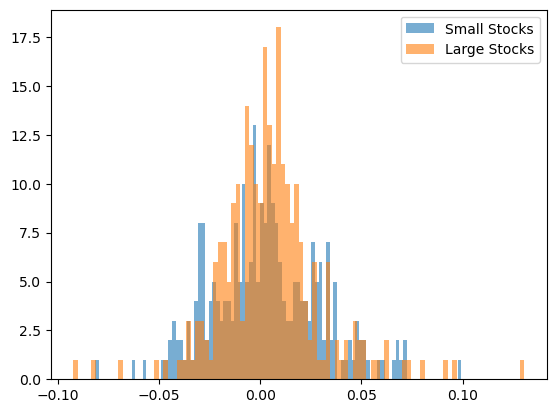


2000-05-01   -0.0386
2000-06-01    0.0995
2000-07-01   -0.0094
2000-08-01   -0.0095
2000-09-01    0.0027
               ...  
2021-09-01    0.0112
2021-10-01   -0.0270
2021-11-01   -0.0170
2021-12-01   -0.0078
2022-01-01   -0.0401
Name: SMB, Length: 261, dtype: float64

2000-05-01    0.0405
2000-06-01   -0.0831
2000-07-01    0.0572
2000-08-01   -0.0306
2000-09-01    0.0270
               ...  
2021-09-01   -0.0192
2021-10-01    0.0171
2021-11-01    0.0719
2021-12-01    0.0488
2022-01-01    0.0077
Name: RMW, Length: 261, dtype: float64


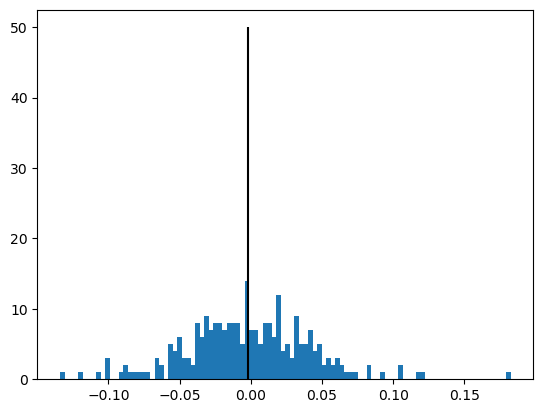

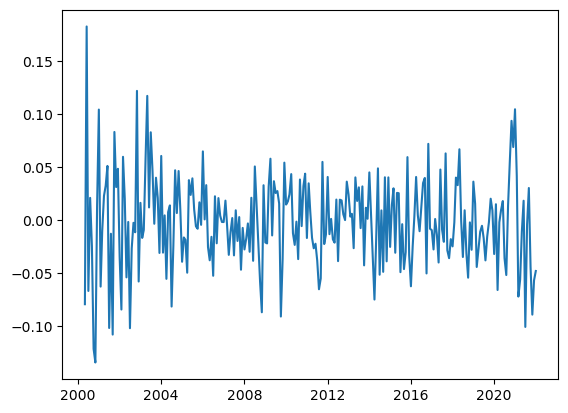

Annualised SMB = -0.026%
t-statistic: -0.82
p-value: 0.41


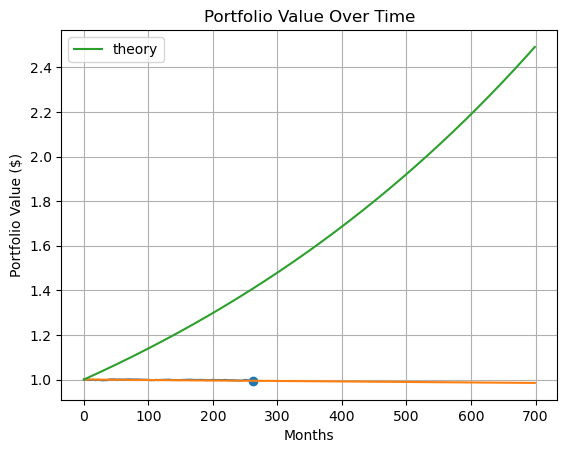

cumulative returns 0.9942711254394689 1 0.9953099597583376 0.9947466143211144


In [21]:
import pandas as pd
import io
from scipy.stats import t

df=fetch_ff5_monthly()
# Visualize the DataFrame
print(df)

plt.hist(df.iloc[443:-44,1], bins=100, alpha=0.6, label='Small Stocks')
plt.hist(df.iloc[443:-44,3], bins=100, alpha=0.6, label='Large Stocks')
plt.legend()
plt.show()

# Replace -99.99 and -999 with NaN
df.iloc[:, 1] = df.iloc[:, 1].replace([-99.99, -999], pd.NA)
df.iloc[:, 3] = df.iloc[:, 3].replace([-99.99, -999], pd.NA)

# Perform subtraction
SMB = df.iloc[442:-43, 1] - df.iloc[442:-43, 3]


print(df.iloc[442:-43,1])
print(df.iloc[442:-43,3])
plt.hist(SMB, bins=100)
plt.vlines(np.mean(SMB), ymin=0, ymax=50, color='black')
plt.show()

plt.plot(SMB)
plt.show()

monthly_returns = SMB
cumulative_returns = [1]
for ret in monthly_returns:
    cumulative_returns.append(cumulative_returns[-1] * (1 + ret/100))

# 1+r = (E/S)^(12/m) 
SMB = (cumulative_returns[-1]/cumulative_returns[0])**(12/len(SMB))-1

print(f'Annualised SMB = {round(SMB*100,3)}%') 

# Calculate the mean and standard deviation of monthly HML returns
mean_return = np.mean(monthly_returns)
std_dev = np.std(monthly_returns)

# Number of observations (number of months)
n = len(monthly_returns)

# Calculate the t-statistic
t_stat = mean_return / (std_dev / np.sqrt(n))

# Calculate the degrees of freedom
degrees_of_freedom = n - 1

# Calculate the p-value
p_value = t.sf(np.abs(t_stat), degrees_of_freedom) * 2  # two-tailed test

print(f't-statistic: {round(t_stat,2)}')
print(f'p-value: {round(p_value,2)}')

m = np.arange(0,700,1)
# Plot the cumulative returns
plt.plot(cumulative_returns)
plt.plot(m, 1*(1+SMB)**(m/12))
plt.plot(m, 1*(1+0.0158)**(m/12), label='theory')
plt.title('Portfolio Value Over Time')
plt.xlabel('Months')
#plt.scatter(len(cumulative_returns), cumulative_returns[-1])
plt.scatter(len(cumulative_returns), cumulative_returns[-3])
#plt.scatter(len(cumulative_returns), cumulative_returns[-3])
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.show()

print("cumulative returns", cumulative_returns[-1], cumulative_returns[0], cumulative_returns[-3], cumulative_returns[-2])

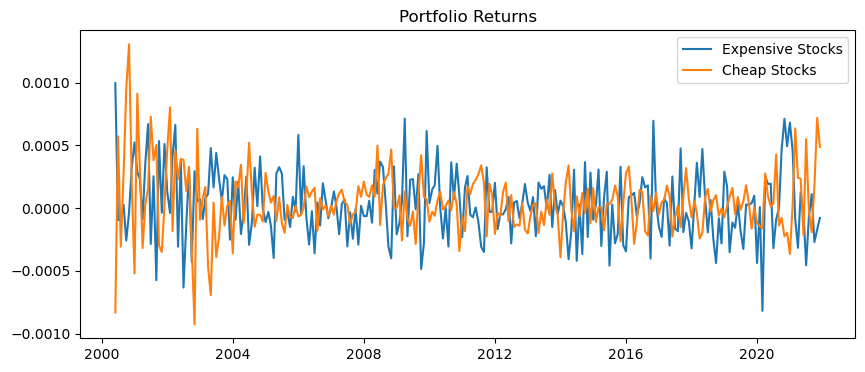

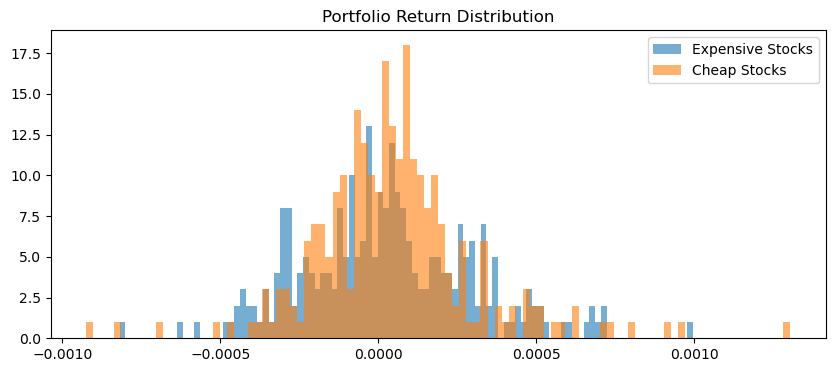

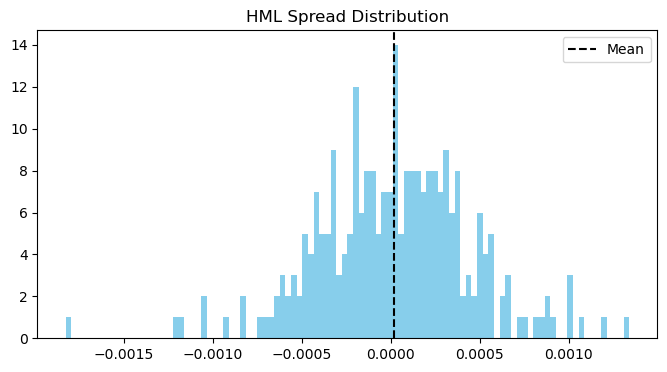

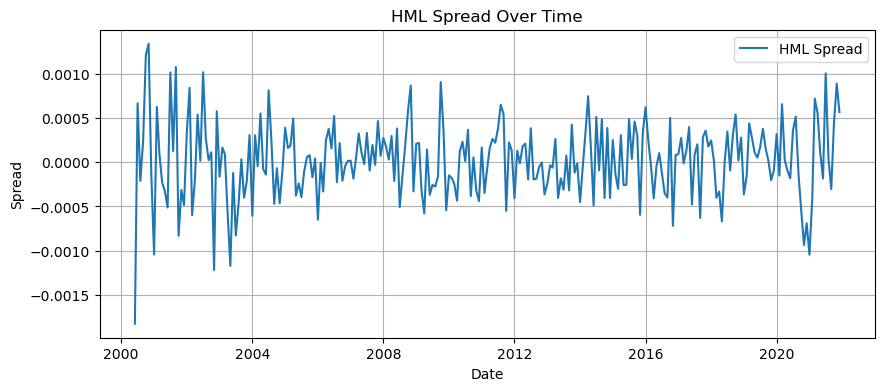

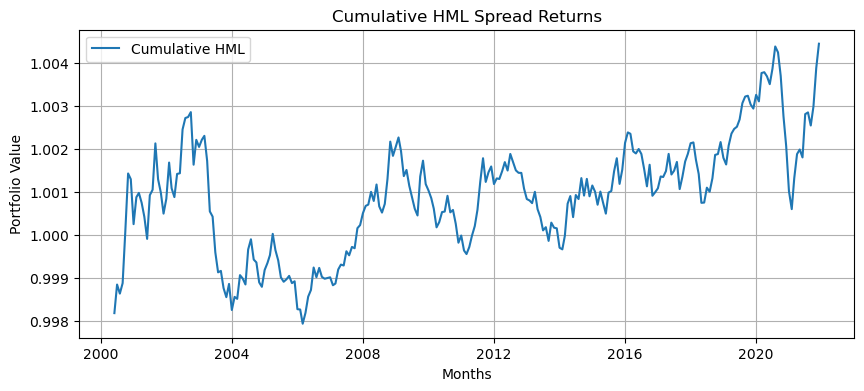

Annualised HML = 0.03%
t-statistic: 0.6442
p-value: 0.5200


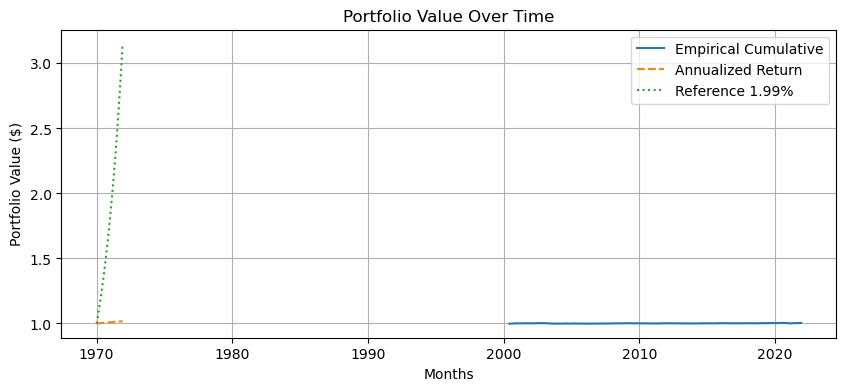

In [22]:
df=fetch_ff5_monthly()

# Select relevant columns for High and Low portfolios
Low = pd.to_numeric(df.iloc[443:-44, 1], errors='coerce') / 100   # convert to decimals
High = pd.to_numeric(df.iloc[443:-44, 3], errors='coerce') / 100  # convert to decimals

# -----------------------------
# Plots
# -----------------------------
plt.figure(figsize=(10,4))
plt.plot(Low, label='Expensive Stocks')
plt.plot(High, label='Cheap Stocks')
plt.title('Portfolio Returns')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(Low, bins=100, alpha=0.6, label='Expensive Stocks')
plt.hist(High, bins=100, alpha=0.6, label='Cheap Stocks')
plt.title('Portfolio Return Distribution')
plt.legend()
plt.show()

# -----------------------------
# Compute HML Spread
# -----------------------------
HML = High - Low

plt.figure(figsize=(8,4))
plt.hist(HML, bins=100, color='skyblue')
plt.axvline(np.mean(HML), color='black', linestyle='--', label='Mean')
plt.title('HML Spread Distribution')
plt.legend()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(HML, label='HML Spread')
plt.title('HML Spread Over Time')
plt.xlabel('Date')
plt.ylabel('Spread')
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Cumulative Returns
# -----------------------------
cumulative = (1 + HML).cumprod()  # cumulative returns as Series

plt.figure(figsize=(10,4))
plt.plot(cumulative, label='Cumulative HML')
plt.title('Cumulative HML Spread Returns')
plt.xlabel('Months')
plt.ylabel('Portfolio Value')
plt.grid(True)
plt.legend()
plt.show()

# -----------------------------
# Annualized Return
# -----------------------------
annualized = (cumulative.iloc[-1] / cumulative.iloc[0])**(12/len(HML)) - 1
print(f"Annualised HML = {annualized*100:.2f}%")

# -----------------------------
# T-Statistic & P-Value
# -----------------------------
mean_return = np.mean(HML)
std_dev = np.std(HML)
n = len(HML)
t_stat = mean_return / (std_dev / np.sqrt(n))
p_value = t.sf(np.abs(t_stat), n-1) * 2  # two-tailed

print(f"t-statistic: {t_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# -----------------------------
# Plot Cumulative vs Theory
# -----------------------------
m = np.arange(0,700,1)
plt.figure(figsize=(10,4))
plt.plot(cumulative, label='Empirical Cumulative')
plt.plot(m, 1*(1+annualized)**(m/12), label='Annualized Return', linestyle='--')
plt.plot(m, 1*(1+0.0199)**(m/12), label='Reference 1.99%', linestyle=':')
plt.title('Portfolio Value Over Time')
plt.xlabel('Months')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.show()


        -1.14  0.32   0.43  -1.61  -0.11  0.60  0.27   0.55  -2.34  -0.69  \
196307                                                                      
196308   5.84  5.02   5.54   6.07   5.35  5.45  4.53   6.47   5.40   6.90   
196309  -1.43 -1.09  -1.08  -0.62  -1.39 -2.44 -0.48  -1.33  -0.83  -0.37   
196310   2.28  1.70   5.98   2.66   0.93  1.32  3.22   7.39   2.91   2.37   
196311   0.39  0.02  -2.04   0.74  -1.12 -1.42  0.88  -3.47   1.85  -0.62   
196312   2.10  2.10   2.42   2.22   3.09  2.14  2.41   1.12   2.19   2.26   
...       ...   ...    ...    ...    ...   ...   ...    ...    ...    ...   
202311   7.49  8.49  11.38   8.13   8.61  7.59  9.25  13.06  11.17   5.69   
202312   7.17  4.34   5.32   6.31   4.94  4.91  4.07   7.19   5.52   6.98   
202401   0.72  0.33   2.64   0.04  -0.05  1.59  2.35   1.75  -0.55   0.54   
202402   4.28  2.92   9.22   4.11   2.62  4.36  6.37  10.13   5.18   3.24   
202403   4.62  2.84   3.05   4.71   2.07  3.97  3.27   3.48   5.29   4.23   

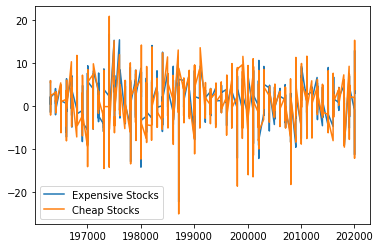

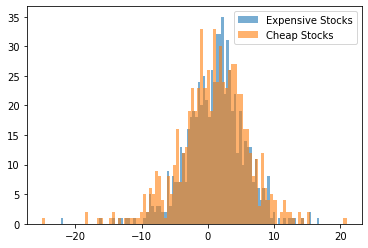

196307
196308    0.30
196309   -0.35
196310   -3.70
196311    2.43
196312   -0.32
          ... 
202003    0.83
202004   -2.38
202005   -2.03
202006   -0.87
202007   -0.38
Length: 684, dtype: float64
196307
196308     5.54
196309    -1.08
196310     5.98
196311    -2.04
196312     2.42
          ...  
202003   -12.09
202004    15.36
202005     6.33
202006     3.84
202007     7.65
Name: 0.43, Length: 684, dtype: float64
196307
196308     5.84
196309    -1.43
196310     2.28
196311     0.39
196312     2.10
          ...  
202003   -11.26
202004    12.98
202005     4.30
202006     2.97
202007     7.27
Name: -1.14, Length: 684, dtype: float64


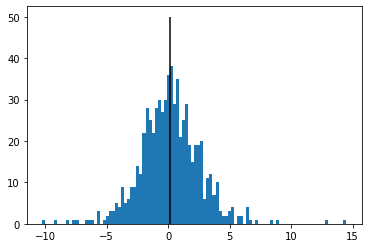

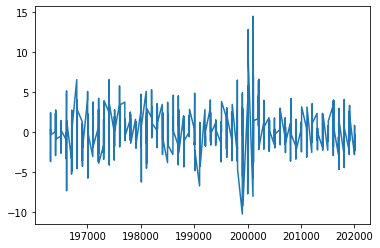

Annualised CMA = 1.98%
t-statistic: 2.04
p-value: 0.04


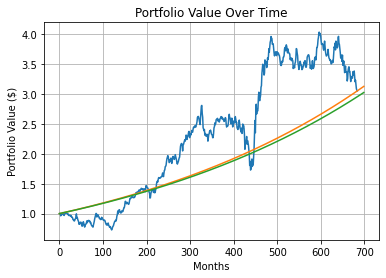

In [16]:
import pandas as pd
import io

# File path
file_path = '/Users/husainmanasawala/Downloads/Portfolios_Formed_on_INV.txt'

# Read data from the text file, skipping the first 12 lines
with open(file_path, 'r') as file:
    for _ in range(18):
        next(file)
    data = []
    for line in file:
        line = line.strip()
        if not line:
            break
        data.append(line)

# Load data into pandas DataFrame
df = pd.read_csv(io.StringIO('\n'.join(data)), sep='\s+', index_col=0)
print(df)
Low = df.iloc[:-44, 0]
High = df.iloc[:-44, 2]

plt.plot(Low, label='Expensive Stocks')
plt.plot(High, label='Cheap Stocks')
plt.legend()
plt.show()

plt.hist(Low, bins=100, alpha=0.6, label='Expensive Stocks')
plt.hist(High, bins=100, alpha=0.6, label='Cheap Stocks')
plt.legend()
plt.show()

Inv = Low-High 
print(Inv)
print(High)
print(Low)

plt.hist(Inv, bins=100)
plt.vlines(np.mean(Inv), ymin=0, ymax=50, color='black')
plt.show()

plt.plot(Inv)
plt.show()

monthly_returns = Inv
cumulative_returns = [1]
for ret in monthly_returns:
    cumulative_returns.append(cumulative_returns[-1] * (1 + ret/100))


# 1+r = (E/S)^(12/m)
Inv = (cumulative_returns[-1]/cumulative_returns[0])**(12/len(Inv))-1
print(f'Annualised CMA = {round(Inv*100,2)}%') 

# Calculate the mean and standard deviation of monthly HML returns
mean_return = np.mean(monthly_returns)
std_dev = np.std(monthly_returns)

# Number of observations (number of months)
n = len(monthly_returns)

# Calculate the t-statistic
t_stat = mean_return / (std_dev / np.sqrt(n))

# Calculate the degrees of freedom
degrees_of_freedom = n - 1

# Calculate the p-value
p_value = t.sf(np.abs(t_stat), degrees_of_freedom) * 2  # two-tailed test

print(f't-statistic: {round(t_stat,2)}')
print(f'p-value: {round(p_value,2)}')

m = np.arange(0,700,1)
# Plot the cumulative returns
plt.plot(cumulative_returns)
#plt.plot(m, 10000*(1+0.04116140051238273/100)**(m))
plt.plot(m, 1*(1+Inv)**(m/12))
plt.plot(m, 1*(1+1.92/100)**(m/12))
plt.title('Portfolio Value Over Time')
plt.xlabel('Months')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)

plt.show()

        -0.84  0.44  0.00  -0.65  1.10  -0.12  -0.99  0.53  -1.44  -0.19  \
196307                                                                     
196308   5.44  4.90  5.81   4.84  4.36   5.41   5.44  6.01   5.53   4.45   
196309  -1.63 -0.85 -1.44  -2.15 -2.11   0.53  -1.78 -1.48  -3.02  -1.65   
196310   0.90  1.48  5.86   0.82  0.30   2.38   2.65  6.86   0.77   0.85   
196311  -1.44  0.27 -1.35  -1.04 -1.03   0.99   0.39 -2.41   0.18  -1.74   
196312   2.14  2.38  2.01   0.70  4.02   1.38   2.58  1.77   1.86   0.03   
...       ...   ...   ...    ...   ...    ...    ...   ...    ...    ...   
202311  12.53  8.72  8.75  13.85  9.77   9.68   7.70  9.22  16.73  12.30   
202312   7.49  6.51  3.81   7.77  6.99   6.82   4.56  4.00  14.41   4.21   
202401   0.72  0.90  1.74   0.69  0.22   0.90   1.84  1.52  -2.99   2.85   
202402   6.34  5.55  5.32   8.16  3.87   6.52   6.83  3.89   8.83   7.79   
202403   1.90  4.45  2.80   0.67  4.14   4.24   4.48  1.97  -0.95   1.55   

        -1.

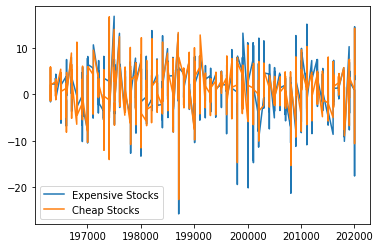

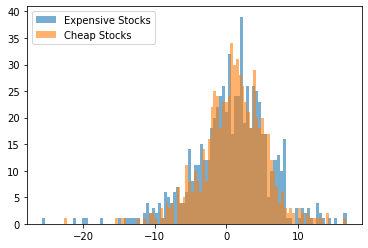

196307
196308    0.37
196309    0.19
196310    4.96
196311    0.09
196312   -0.13
          ... 
202003    6.95
202004   -0.33
202005   -1.34
202006    1.07
202007    1.03
Length: 684, dtype: float64
196307
196308     5.81
196309    -1.44
196310     5.86
196311    -1.35
196312     2.01
          ...  
202003   -10.62
202004    14.21
202005     5.41
202006     4.19
202007     6.09
Name: 0.00, Length: 684, dtype: float64
196307
196308     5.44
196309    -1.63
196310     0.90
196311    -1.44
196312     2.14
          ...  
202003   -17.57
202004    14.54
202005     6.75
202006     3.12
202007     5.06
Name: -0.84, Length: 684, dtype: float64


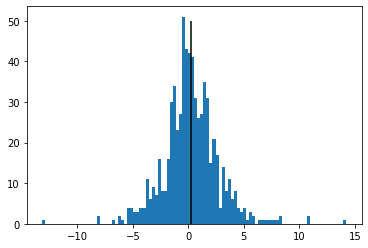

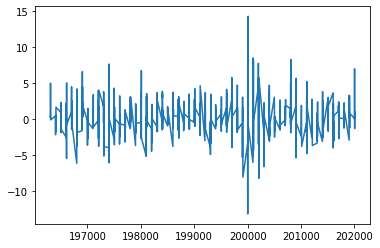

Annualised CMA = 2.56%
t-statistic: 2.53
p-value: 0.01


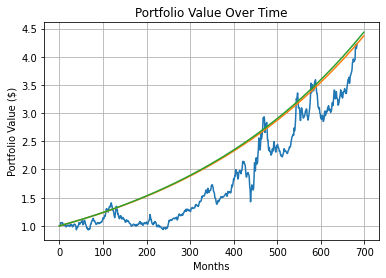

In [6]:
import pandas as pd
import io
from scipy.stats import t

# File path
file_path = '/Users/husainmanasawala/Downloads/Portfolios_Formed_on_OP.txt'

# Read data from the text file, skipping the first 12 lines
with open(file_path, 'r') as file:
    for _ in range(2):
        next(file)
    data = []
    for line in file:
        line = line.strip()
        if not line:
            break
        data.append(line)

# Load data into pandas DataFrame
df = pd.read_csv(io.StringIO('\n'.join(data)), sep='\s+', index_col=0)
print(df)
Low = df.iloc[:-44, 0]
High = df.iloc[:-44, 2]

plt.plot(Low, label='Expensive Stocks')
plt.plot(High, label='Cheap Stocks')
plt.legend()
plt.show()

plt.hist(Low, bins=100, alpha=0.6, label='Expensive Stocks')
plt.hist(High, bins=100, alpha=0.6, label='Cheap Stocks')
plt.legend()
plt.show()

Inv = -(Low-High) 
print(Inv)
print(High)
print(Low)

plt.hist(Inv, bins=100)
plt.vlines(np.mean(Inv), ymin=0, ymax=50, color='black')
plt.show()

plt.plot(Inv)
plt.show()

monthly_returns = Inv
cumulative_returns = [1]
for ret in monthly_returns:
    cumulative_returns.append(cumulative_returns[-1] * (1 + ret/100))


# 1+r = (E/S)^(12/m)
Inv = (cumulative_returns[-1]/cumulative_returns[0])**(12/len(Inv))-1
print(f'Annualised CMA = {round(Inv*100,2)}%') 

# Calculate the mean and standard deviation of monthly HML returns
mean_return = np.mean(monthly_returns)
std_dev = np.std(monthly_returns)

# Number of observations (number of months)
n = len(monthly_returns)

# Calculate the t-statistic
t_stat = mean_return / (std_dev / np.sqrt(n))

# Calculate the degrees of freedom
degrees_of_freedom = n - 1

# Calculate the p-value
p_value = t.sf(np.abs(t_stat), degrees_of_freedom) * 2  # two-tailed test

print(f't-statistic: {round(t_stat,2)}')
print(f'p-value: {round(p_value,2)}')

m = np.arange(0,700,1)
# Plot the cumulative returns
plt.plot(cumulative_returns)
#plt.plot(m, 10000*(1+0.04116140051238273/100)**(m))
plt.plot(m, 1*(1+Inv)**(m/12))
plt.plot(m, 1*(1+2.59/100)**(m/12))
plt.title('Portfolio Value Over Time')
plt.xlabel('Months')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)

plt.show()

           Date       Open       High        Low      Close  Adj Close  Volume
0    2015-03-01  31.260000  32.110001  30.969999  31.760000  31.760000    8673
1    2015-04-01  31.870001  33.500000  31.860001  32.189999  32.189999   46593
2    2015-05-01  31.945210  34.900002  31.420000  32.959999  32.959999   23456
3    2015-06-01  33.130001  33.360001  31.500000  31.820000  31.820000   28274
4    2015-07-01  32.290001  33.320000  30.820000  32.619999  32.619999   10505
..          ...        ...        ...        ...        ...        ...     ...
107  2024-02-01  46.509998  46.805000  45.490002  46.195000  46.195000  189426
108  2024-03-01  46.389999  48.814999  46.099998  48.424999  48.424999  169226
109  2024-04-01  48.424999  49.165001  47.075001  48.599998  48.599998  169221
110  2024-05-01  48.599998  50.380001  48.599998  50.290001  50.290001   55358
111  2024-05-13  50.820000  50.860001  50.410000  50.459999  50.459999     517

[112 rows x 7 columns]
0           NaN
1      1.353

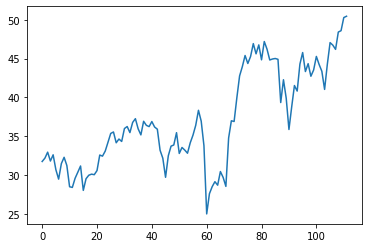

50.45999899999999
[31.76, 32.189999, 32.959999, 31.82, 32.619999, 30.700001, 29.49, 31.489999999999995, 32.29999899999999, 31.244880999999992, 28.509999999999994, 28.419999999999995, 29.589999999999993, 30.379998999999998, 31.179999999999996, 28.040000999999997, 29.540000999999993, 29.989999999999988, 30.129998999999987, 30.059998999999987, 30.589999999999986, 32.58999999999999, 32.450000999999986, 33.099997999999985, 34.22999999999998, 35.369998999999986, 35.560000999999986, 34.169997999999985, 34.650001999999986, 34.33999999999999, 35.999999999999986, 36.25999799999999, 35.47999999999998, 36.79000099999998, 37.26999999999999, 35.97000099999999, 35.185000999999986, 36.935000999999986, 36.41500099999998, 36.252498999999986, 36.900001999999986, 36.200000999999986, 35.919997999999985, 33.205001999999986, 32.179999999999986, 29.72499999999999, 32.494998999999986, 33.73500099999998, 33.88499799999999, 35.47000099999999, 32.794997999999985, 33.564998999999986, 33.22999999999998, 32.82500099

'\nfor group_name, group_data in data.groupby(\'YearMonth\'):\n    print("Group Name:", group_name)\n    print(group_data)\n    print("------------------------")\n'

In [7]:
import pandas as pd

# Read data from the CSS file
data = pd.read_csv('/Users/husainmanasawala/Downloads/ZPRX.DE-2.csv', delimiter=',')
print(data)

# Calculate the monthly returns based on the closing prices
data['Monthly_Return'] = data['Close'].pct_change() * 100

# Print the resulting DataFrame

monthly_returns = data['Monthly_Return']
print(monthly_returns)
cumulative_returns = [31.76]
for ret in monthly_returns:
    retf = float(ret)
    if np.isnan(retf):
        continue
    # print(f'{cumulative_returns[-1]}x{(1 + retf/100)}')
    cumulative_returns.append(cumulative_returns[-1] * (1 + retf/100))

plt.plot(cumulative_returns)
plt.show()
print(cumulative_returns[-1])
print(cumulative_returns)

'''
for group_name, group_data in data.groupby('YearMonth'):
    print("Group Name:", group_name)
    print(group_data)
    print("------------------------")
'''

           Date       Open       High        Low      Close  Adj Close  Volume
0    2015-03-01  27.100000  28.330000  26.900000  28.290001  28.290001   31014
1    2015-04-01  28.240000  29.090000  27.020000  27.020000  27.020000   19173
2    2015-05-01  30.173000  27.990000  26.350000  27.570000  27.570000   34254
3    2015-06-01  27.799999  27.799999  26.780001  26.780001  26.780001    4108
4    2015-07-01  27.080000  27.510000  25.629999  26.520000  26.520000     377
..          ...        ...        ...        ...        ...        ...     ...
107  2024-02-01  56.009998  57.540001  54.500000  56.919998  56.919998  190771
108  2024-03-01  57.040001  60.169998  56.209999  59.919998  59.919998  248901
109  2024-04-01  59.919998  59.919998  55.299999  57.029999  57.029999  315723
110  2024-05-01  57.029999  58.830002  56.830002  58.619999  58.619999   43059
111  2024-05-13  58.900002  58.970001  58.779999  58.959999  58.959999    1485

[112 rows x 7 columns]
0           NaN
1     -4.489

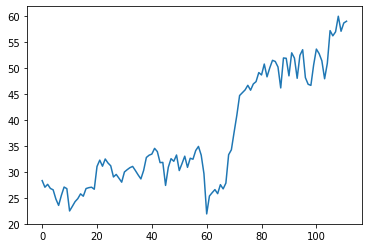

58.9599969158714
[28.29, 27.01999904489222, 27.56999902545072, 26.780000053375744, 26.519999062566306, 24.749999125132582, 23.51999916861084, 25.4400001007423, 27.049998043831803, 26.742900054687155, 22.45000020643335, 23.329999175326986, 24.23999914316014, 24.8199991226582, 25.73999909013787, 25.29000010604452, 26.759999054082733, 26.92999904807354, 27.019999044892206, 26.629998058678034, 31.009998903852978, 32.2299988607282, 31.059997902085613, 32.44999985295158, 31.67999888016971, 31.13999789925776, 28.989998975256306, 29.4799989579357, 28.749998983739868, 27.989999010604482, 29.94999994132202, 30.389997925768892, 30.779999911983033, 31.01999890349951, 30.224998931601313, 29.384998961293785, 28.61499898851188, 30.239998931071085, 32.74000084270057, 33.179998827147436, 33.39499881954758, 34.49499778066461, 33.87499880258045, 31.74999887769533, 31.79499887610466, 27.36499903269709, 30.854998909331947, 32.50999685083078, 32.00999686850487, 33.21499882591025, 30.2249989316013, 31.564999

In [8]:
import pandas as pd

# Read data from the CSS file
data = pd.read_csv('/Users/husainmanasawala/Downloads/ZPRV.DE.csv', delimiter=',')
print(data)

# Calculate the monthly returns based on the closing prices
data['Monthly_Return'] = data['Close'].pct_change() * 100

# Print the resulting DataFrame

monthly_returns = data['Monthly_Return']
        
print(monthly_returns)
cumulative_returns = [28.29]
for ret in monthly_returns:
    retf = float(ret)
    if np.isnan(retf):
        continue
    # print(f'{cumulative_returns[-1]}x{(1 + retf/100)}')
    cumulative_returns.append(cumulative_returns[-1] * (1 + retf/100))

plt.plot(cumulative_returns)
plt.show()
print(cumulative_returns[-1])
print(cumulative_returns)

# beta_m, beta_smb, ...

In [9]:
# MSCI World - Market
# SMB, HML, RMW, CMA - From Ken French website (For EU and Aus)
# Bonds - ?? -> Beta_M * "Market - Bonds"

# M, SMB, HML, RMW, CMA - numbers and monthly return 
# EU and Aussie ETFs - monthly returns
# Regression 




           Date        Open        High         Low       Close   Adj Close  \
0    2009-04-01   18.695900   15.140000   15.140000   15.140000   15.140000   
1    2009-05-01   15.140000   16.120001   15.190000   15.190000   15.190000   
2    2009-06-01   15.050000   15.680000   15.050000   15.170000   15.170000   
3    2009-07-01   15.170000    0.000000    0.000000   15.170000   15.170000   
4    2009-08-01   15.170000    0.000000    0.000000   16.580000   16.580000   
..          ...         ...         ...         ...         ...         ...   
178  2024-02-01  128.725006  135.080002  127.934998  134.380005  134.380005   
179  2024-03-01  135.145004  139.389999  133.470001  139.225006  139.225006   
180  2024-04-01  139.225006  139.985001  133.679993  136.274994  136.274994   
181  2024-05-01  136.274994  140.360001  134.645004  139.720001  139.720001   
182  2024-05-20  139.949997  140.585007  139.949997  140.585007  140.585007   

     Volume  
0       210  
1     43242  
2     194

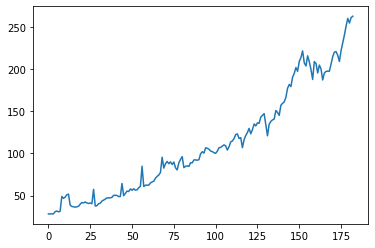

262.69153553698806
[28.29, 28.383428005284014, 28.346056803170406, 28.346056803170406, 30.980726552179647, 31.76552179656538, 30.7004425363276, 31.47589311162483, 48.96430957727872, 46.743901472258905, 48.14158256274767, 50.98721274768823, 51.77368969616908, 38.71656352113606, 37.128291168428, 36.791950349405546, 36.28743725231176, 36.735891677675035, 37.33383091149273, 39.89375825627477, 41.7996914326288, 41.351233270145315, 42.4163162675033, 41.33255140620871, 40.6598678996037, 41.295178335535006, 40.379585752311755, 57.42328117569352, 37.67017173051518, 38.08125308520475, 40.36089828269484, 40.99621058718625, 43.53744859379127, 44.65858652575956, 45.81709379128136, 47.2745688051519, 47.25588694121531, 47.33062747688241, 47.9098792410832, 50.413751651254934, 50.33901111558782, 50.2082119081902, 48.788106227873165, 48.93759103632758, 64.39973905482162, 49.853183619550826, 52.56259390422718, 55.32806659775425, 54.86092657133417, 57.906677675032974, 56.3183997166446, 58.11221928665781, 

In [10]:
import pandas as pd

# Read data from the CSS file
data = pd.read_csv('/Users/husainmanasawala/Downloads/SC0H.DE.csv', delimiter=',')
print(data)

# Calculate the monthly returns based on the closing prices
data['Monthly_Return'] = data['Close'].pct_change() * 100

# Print the resulting DataFrame

monthly_returns = data['Monthly_Return']
        
print(monthly_returns)
cumulative_returns = [28.29]
for ret in monthly_returns:
    retf = float(ret)
    if np.isnan(retf):
        continue
    # print(f'{cumulative_returns[-1]}x{(1 + retf/100)}')
    cumulative_returns.append(cumulative_returns[-1] * (1 + retf/100))

plt.plot(cumulative_returns)
plt.show()
print(cumulative_returns[-1])
print(cumulative_returns)

Int64Index([196307, 196308, 196309, 196310, 196311, 196312, 196401, 196402,
            196403, 196404,
            ...
            202306, 202307, 202308, 202309, 202310, 202311, 202312, 202401,
            202402, 202403],
           dtype='int64', name='Lo', length=729)
0
684
0.01956710252486049
Annualised CMA = 1.96%
t-statistic: 2.02
p-value: 0.04


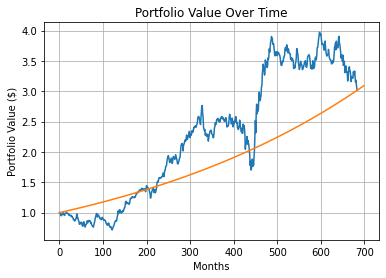

In [75]:
import pandas as pd
import numpy as np
import io
from scipy.stats import t
import matplotlib.pyplot as plt

def annualise_return(file_path, skip=0, ordering=1):
            
    # Read data from the text file, skipping the first 12 lines
    with open(file_path, 'r') as file:
        for _ in range(skip):
            next(file)
        data = []
        for line in file:
            line = line.strip()
            if not line:
                break
            data.append(line)
    
    #print(data)
    # Load data into pandas DataFrame
    df = pd.read_csv(io.StringIO('\n'.join(data)), sep='\s+', index_col=0)

    # print(df)
    #start_index = df[df[] == 196307].index[0]
    #end_index = df[df['Value'] == 202007].index[0]
    print(df.index)
    start_index = df.index.get_loc(196307)
    end_index = df.index.get_loc(202007)
    print(start_index)
    print(end_index)

    Low = df.iloc[start_index:end_index, 0]
    High = df.iloc[start_index:end_index, 2]

    Inv = ordering*(High-Low) 

    monthly_returns = Inv
    cumulative_returns = [1]
    for ret in monthly_returns:
        cumulative_returns.append(cumulative_returns[-1] * (1 + ret/100))

    # 1+r = (E/S)^(12/m)
    Inv = (cumulative_returns[-1]/cumulative_returns[0])**(12/len(Inv))-1
    print(Inv)
    print(f'Annualised CMA = {round(Inv*100,2)}%') 

    # Calculate the mean and standard deviation of monthly HML returns
    mean_return = np.mean(monthly_returns)
    std_dev = np.std(monthly_returns)

    # Number of observations (number of months)
    n = len(monthly_returns)

    # Calculate the t-statistic
    t_stat = mean_return / (std_dev / np.sqrt(n))

    # Calculate the degrees of freedom
    degrees_of_freedom = n - 1

    # Calculate the p-value
    p_value = t.sf(np.abs(t_stat), degrees_of_freedom) * 2  # two-tailed test

    print(f't-statistic: {round(t_stat,2)}')
    print(f'p-value: {round(p_value,2)}')
    return cumulative_returns, Inv, t_stat, p_value

    
def plot_returns(cumulative_returns):
    m = np.arange(0,700,1)
    # Plot the cumulative returns
    plt.plot(cumulative_returns)
    #plt.plot(m, 10000*(1+0.04116140051238273/100)**(m))
    plt.plot(m, 1*(1+Inv)**(m/12))
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Months')
    plt.ylabel('Portfolio Value ($)')
    plt.grid(True)

    plt.show()
    
# File path
#file_path = '/Users/husainmanasawala/Downloads/Portfolios_Formed_on_OP.txt' # 1, 1
file_path = '/Users/husainmanasawala/Downloads/Portfolios_Formed_on_INV.txt' # 17, -1
#file_path = '/Users/husainmanasawala/Downloads/Portfolios_Formed_on_BE-ME.txt'# 23, 1
#file_path = '/Users/husainmanasawala/Downloads/Portfolios_Formed_on_ME.txt' # 14, -1

cumulative_returns, Inv, t_stat, p_value = annualise_return(file_path, skip = 17, ordering = -1)
plot_returns(cumulative_returns)

Archive contents: ['F-F_Research_Data_5_Factors_2x3.csv']
Using CSV file: F-F_Research_Data_5_Factors_2x3.csv
Parsed header: ['', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
First few data lines:
1: 196307,   -0.39,   -0.48,   -0.81,    0.64,   -1.15,    0.27
2: 196308,    5.08,   -0.80,    1.70,    0.40,   -0.38,    0.25
3: 196309,   -1.57,   -0.43,    0.00,   -0.78,    0.15,    0.27
4: 196310,    2.54,   -1.34,   -0.04,    2.79,   -2.25,    0.29
5: 196311,   -0.86,   -0.85,    1.73,   -0.43,    2.27,    0.27

Final DataFrame preview:
            Mkt-RF     SMB     HML     RMW     CMA      RF
                                                          
1963-07-01 -0.0039 -0.0048 -0.0081  0.0064 -0.0115  0.0027
1963-08-01  0.0508 -0.0080  0.0170  0.0040 -0.0038  0.0025
1963-09-01 -0.0157 -0.0043  0.0000 -0.0078  0.0015  0.0027
1963-10-01  0.0254 -0.0134 -0.0004  0.0279 -0.0225  0.0029
1963-11-01 -0.0086 -0.0085  0.0173 -0.0043  0.0227  0.0027


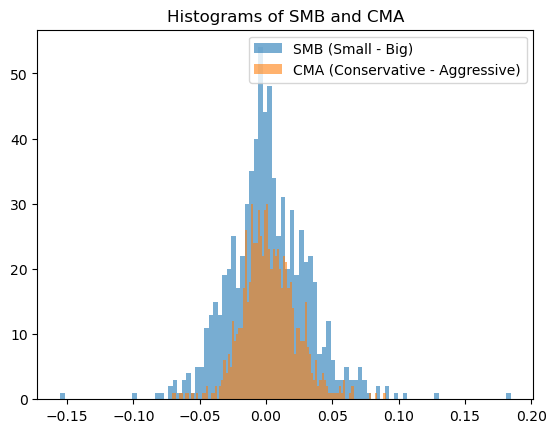

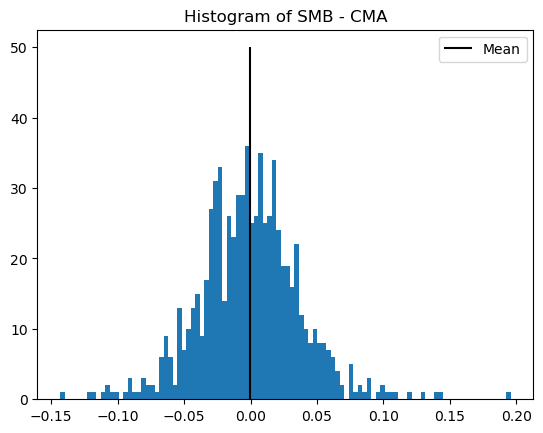

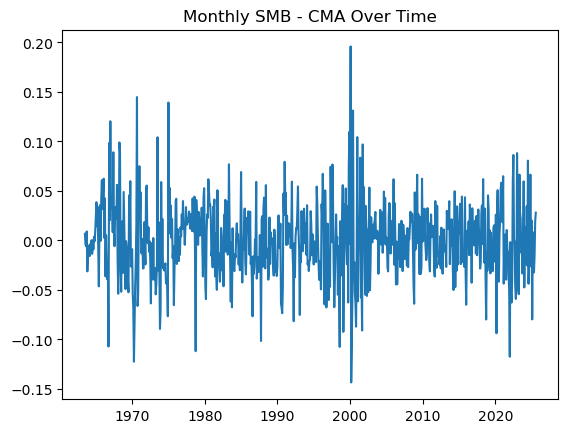

Annualised SMB-CMA = -0.008%
t-statistic: -0.47
p-value: 0.6387


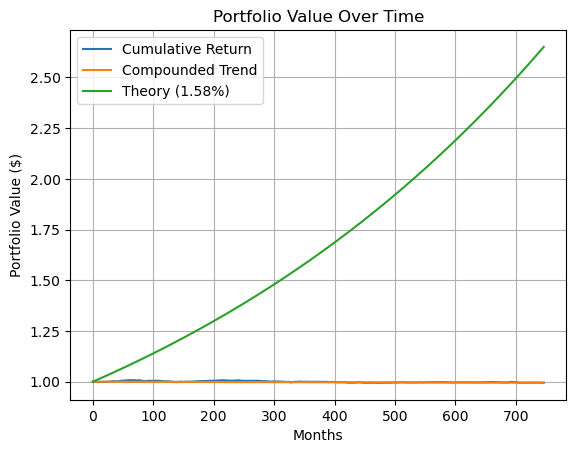

Final cumulative return: 0.995074114186561
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.968
Model:                            OLS   Adj. R-squared:                  0.968
Method:                 Least Squares   F-statistic:                     4534.
Date:                Fri, 17 Oct 2025   Prob (F-statistic):               0.00
Time:                        18:28:54   Log-Likelihood:                 2357.5
No. Observations:                 746   AIC:                            -4703.
Df Residuals:                     740   BIC:                            -4675.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import t
import requests
import zipfile
import io
import statsmodels.api as sm
# --- DOWNLOAD AND UNZIP ---
url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip"
response = requests.get(url)

with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    print("Archive contents:", z.namelist())

    # Dynamically find the CSV file
    csv_filename = next(name for name in z.namelist() if name.lower().endswith('.csv'))
    print(f"Using CSV file: {csv_filename}")

    with z.open(csv_filename) as f:
        lines = f.read().decode("utf-8").splitlines()

# --- PARSING SECTION ---

# Find header
header_line_index = next(i for i, line in enumerate(lines) if "Mkt-RF" in line and "RF" in line)
header = lines[header_line_index].strip().split(",")

# Read data lines until the first line that doesn't start with a year+month
data_lines = []
for line in lines[header_line_index + 1:]:
    if not line.strip() or not line[:6].isdigit():
        break
    data_lines.append(line.strip())

print("Parsed header:", header)
print("First few data lines:")
for i, line in enumerate(data_lines[:5]):
    print(f"{i+1}: {line}")

# Read DataFrame
df = pd.read_csv(io.StringIO("\n".join(data_lines)), names=header)

# Parse date and set as index
date_col = df.columns[0]
df[date_col] = pd.to_datetime(df[date_col], format="%Y%m")
df.set_index(date_col, inplace=True)

# Convert from percentages to decimals
df = df / 100

print("\nFinal DataFrame preview:")
print(df.head())

# Plot histograms for SMB and CMA as analogues to small vs large stocks
plt.hist(df['SMB'], bins=100, alpha=0.6, label='SMB (Small - Big)')
plt.hist(df['CMA'], bins=100, alpha=0.6, label='CMA (Conservative - Aggressive)')
plt.legend()
plt.title("Histograms of SMB and CMA")
plt.show()

# Remove missing values from SMB and CMA
smb = df['SMB'].dropna()
cma = df['CMA'].dropna()
# Plot SMB - CMA 
SMB_minus_CMA = smb - cma

plt.hist(SMB_minus_CMA, bins=100)
plt.vlines(np.mean(SMB_minus_CMA), ymin=0, ymax=50, color='black', label='Mean')
plt.title('Histogram of SMB - CMA')
plt.legend()
plt.show()

plt.plot(SMB_minus_CMA)
plt.title('Monthly SMB - CMA Over Time')
plt.show()
# --- Cumulative returns calculation ---
monthly_returns = SMB_minus_CMA
cumulative_returns = [1]
for ret in monthly_returns:
    cumulative_returns.append(cumulative_returns[-1] * (1 + ret / 100))

# Annualized return calculation
n_months = len(monthly_returns)
annualized_return = (cumulative_returns[-1] / cumulative_returns[0])**(12 / n_months) - 1
print(f'Annualised SMB-CMA = {round(annualized_return*100,3)}%')

# t-statistic and p-value
mean_return = np.mean(monthly_returns)
std_dev = np.std(monthly_returns)
n = len(monthly_returns)
t_stat = mean_return / (std_dev / np.sqrt(n))
p_value = t.sf(np.abs(t_stat), n - 1) * 2  # two-tailed test

print(f't-statistic: {round(t_stat, 2)}')
print(f'p-value: {round(p_value, 4)}')

# Plot cumulative returns
m = np.arange(0, len(cumulative_returns))
plt.plot(cumulative_returns, label="Cumulative Return")
plt.plot(m, cumulative_returns[0] * (1 + annualized_return)**(m / 12), label="Compounded Trend")
plt.plot(m, cumulative_returns[0] * (1 + 0.0158)**(m / 12), label="Theory (1.58%)")
plt.title('Portfolio Value Over Time')
plt.xlabel('Months')
plt.ylabel('Portfolio Value ($)')
plt.grid(True)
plt.legend()
plt.show()

print("Final cumulative return:", cumulative_returns[-1])

#Running a regression
X = df[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]
X = sm.add_constant(X)

# Simulate some portfolio returns
y = X['Mkt-RF'] * 1.2 + X['SMB'] * 0.3 + np.random.normal(0, 0.01, size=len(X))  # synthetic
model = sm.OLS(y, X).fit()
print(model.summary())